## `GO_MWU` functional enrichment analysis

Here we will test for enrichment of GO categories in different groups of transcripts. The code is run by simply editing the names of the inputs and uncommenting certain lines of code as needed. See Mikhail Matz's [GitHub page](https://github.com/z0on/GO_MWU) on `GO_MWU` for more info. The code below is identical to the original script with the exception of some minor tweaks for plotting. 

All functional enrichment analyses in the report were carried out using the `dissim_MF_GO_MWU_annot_1e-50.tsv` annotations file, which contains just matching GO terms from the arthropod eggNOG database with e-values at or below 1e-50. Putative contaminants are also discarded. See the `EnTAP2GO.py` script for more details about how to generate these GO term tables. 

Rather than repeat all of these lines of code for the various tests and datasets, just use the files specified below as `input` and re-run, changing the filepath for saving output images. Also make sure to switch among GO divisions, including in output filepath as well, so there are three plots each.


>Infected vs. control DESeq2 pvalues, Mann-Whitney U test:
>>`GO_MWU_PvC_pval.csv`

>Infected vs. control DESeq2 LFCs, Mann-Whitney U test:
>>`GO_MWU_PvC_LFC.csv`

>Infected vs. control DESeq2, Fisher's exact test:
>>`GO_MWU_PvC_fisher.csv`

>Range:condition interaction DESeq2 pvalues, Mann-Whitney U test:
>>`GO_MWU_interaction_pval.csv`

>Range:condition interaction DESeq2, Fisher's exact test:
>>`GO_MWU_interaction_fisher.csv` (No significant transcripts found except for CC)

>WGCNA_FP modules (infection and sex):

>>`GO_MWU_WGCNA_FP_kMEgreenyellow_fisher.csv`

>>`GO_MWU_WGCNA_FP_kMEmidnightblue_fisher.csv`

>>`GO_MWU_WGCNA_FP_kMEsalmon_fisher.csv`


>Within range infected vs. control:

>> `GO_MWU_native.PvC_pval.csv`

>> `GO_MWU_invasive.PvC_pval.csv`

>> `GO_MWU_absent.PvC_pval.csv`

>Range:condition interaction contrasts, pval

>> `GO_MWU_interaction_AvN_pval.csv`

>> `GO_MWU_interaction_IvN_pval.csv`

>> `GO_MWU_interaction_AvI_pval.csv`

>Range:condition interaction contrasts, fisher

>> `GO_MWU_interaction_AvN_fisher.csv`

>> `GO_MWU_interaction_IvN_fisher.csv`

>> `GO_MWU_interaction_AvI_fisher.csv`


Note that `GO_MWU` returns a message about "terms without a defined level." Apparently `EnTAP` is returning some deprecated GO terms, as was also noted [here](https://github.com/fishercera/TreehopperSeq/blob/master/GoSeq_Walkthrough.md).

The analysis of the WGCNA modules was done using solely a Fisher test. Outputs from WGCNA were converted to this format using `script.awk` in the `GO_MWU/` directory. Non-zero kMEs were coverted to ones. Tests solely for GO term inclusion in module. Skips second part of WGCNA GO_MWU analysis described on the GitHub page. 

In [32]:
input="GO_MWU_WGCNA_FP_kMEgreenyellow.csv" # two columns of comma-separated values: gene id, continuous measure of significance. To perform standard GO enrichment analysis based on Fisher's exact test, use binary measure (0 or 1, i.e., either sgnificant or not).
goAnnotations="GO_MWU_annot_1e-50.tsv" # two-column, tab-delimited, one line per gene, multiple GO terms separated by semicolon. If you have multiple lines per gene, use nrify_GOtable.pl prior to running this script.
goDatabase="go.obo" # download from http://www.geneontology.org/GO.downloads.ontology.shtml
goDivision="MF" # either MF, or BP, or CC
source("gomwu.functions.R")

In [33]:
gomwuStats(input, goDatabase, goAnnotations, goDivision,
	perlPath="perl", # replace with full path to perl executable if it is not in your system's PATH already
	largest=0.1,  # a GO category will not be considered if it contains more than this fraction of the total number of genes
	smallest=5,   # a GO category should contain at least this many genes to be considered
	clusterCutHeight=0.25, # threshold for merging similar (gene-sharing) terms. See README for details.
#	Alternative="g" # by default the MWU test is two-tailed; specify "g" or "l" of you want to test for "greater" or "less" instead. 
	Module=TRUE,Alternative="g" # un-remark this if you are analyzing a SIGNED WGCNA module (values: 0 for not in module genes, kME for in-module genes). In the call to gomwuPlot below, specify absValue=0.001 (count number of "good genes" that fall into the module)
	#Module=TRUE # un-remark this if you are analyzing an UNSIGNED WGCNA module 
)

ERROR: Error in wilcox.test.default(nrg[sgo.yes], nrg[sgo.no], alternative = Alternative): not enough 'y' observations


Warning message in plot.formula(c(1:top) ~ c(1:top), type = "n", axes = F, xlab = "", :
“the formula 'c(1:top) ~ c(1:top)' is treated as 'c(1:top) ~ 1'”Warning message in plot.formula(c(1:top) ~ c(1:top), type = "n", axes = F, xlab = "", :
“the formula 'c(1:top) ~ c(1:top)' is treated as 'c(1:top) ~ 1'”

GO terms dispayed:  23 
"Good genes" accounted for:  109 out of 171 ( 64% )


png 
  2

Warning message in plot.formula(c(1:top) ~ c(1:top), type = "n", axes = F, xlab = "", :
“the formula 'c(1:top) ~ c(1:top)' is treated as 'c(1:top) ~ 1'”Warning message in plot.formula(c(1:top) ~ c(1:top), type = "n", axes = F, xlab = "", :
“the formula 'c(1:top) ~ c(1:top)' is treated as 'c(1:top) ~ 1'”

GO terms dispayed:  23 
"Good genes" accounted for:  0 out of 0 ( NaN% )


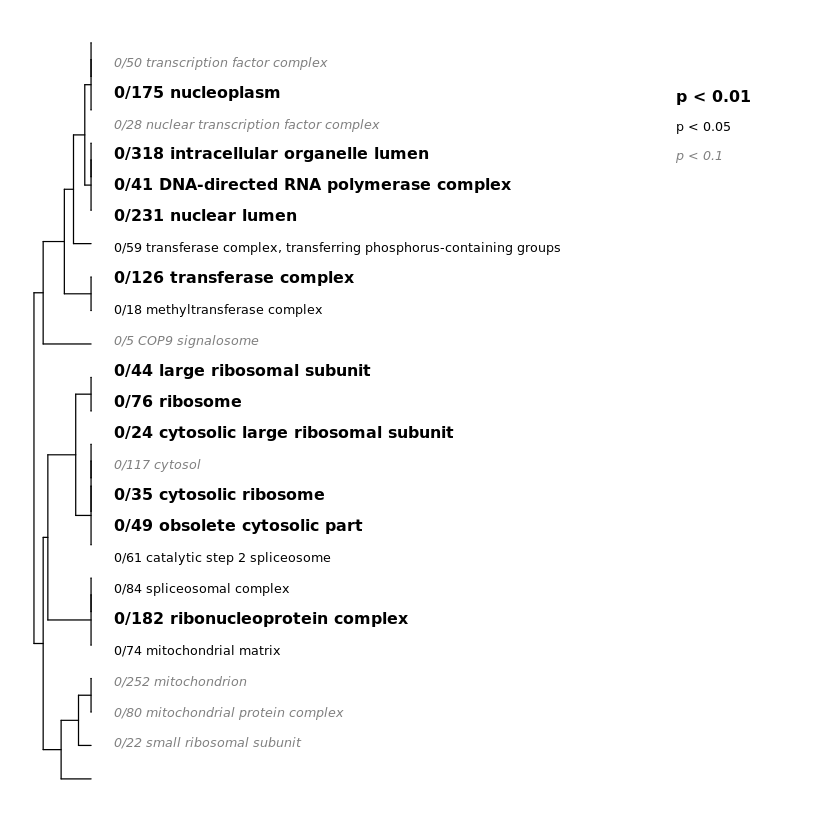

In [26]:
#save plot
png(filename="../vis/GO_MWU_interaction_AvI_fisher_annot_1e-50_CC.png", pointsize=60, height=2200, width=2500)
results=gomwuPlot(input,goAnnotations,goDivision,
#	absValue=-log(0.05,10),  # genes with the measure value exceeding this will be counted as "good genes". This setting is for signed log-pvalues. Specify absValue=0.001 if you are doing Fisher's exact test for standard GO enrichment or analyzing a WGCNA module (all non-zero genes = "good genes").
	absValue=0.001, # un-remark this if you are using log2-fold changes
	level1=0.1, # FDR threshold for plotting. Specify level1=1 to plot all GO categories containing genes exceeding the absValue.
	level2=0.05, # FDR cutoff to print in regular (not italic) font.
	level3=0.01, # FDR cutoff to print in large bold font.
	txtsize=1.2,    # decrease to fit more on one page, or increase (after rescaling the plot so the tree fits the text) for better "word cloud" effect
	treeHeight=0.5, # height of the hierarchical clustering tree
	#colors=c("gray0","gray0","gray57","gray57") # these are default colors, un-remar and change if needed
)
dev.off()

#show plot
results=gomwuPlot(input,goAnnotations,goDivision,
	absValue=-log(0.05,10),  # genes with the measure value exceeding this will be counted as "good genes". This setting is for signed log-pvalues. Specify absValue=0.001 if you are doing Fisher's exact test for standard GO enrichment or analyzing a WGCNA module (all non-zero genes = "good genes").
#	absValue=1, # un-remark this if you are using log2-fold changes
	level1=0.1, # FDR threshold for plotting. Specify level1=1 to plot all GO categories containing genes exceeding the absValue.
	level2=0.05, # FDR cutoff to print in regular (not italic) font.
	level3=0.01, # FDR cutoff to print in large bold font.
	txtsize=1.2,    # decrease to fit more on one page, or increase (after rescaling the plot so the tree fits the text) for better "word cloud" effect
	treeHeight=0.5, # height of the hierarchical clustering tree
	#colors=c("gray0","gray0","gray57","gray57") # these are default colors, un-remar and change if needed
)
